# Quality Check Diagnostic Work

## Step 1: Load in Data

In [24]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [25]:
from operational_analysis.methods.quality_check_automation import WindToolKitQualityControlDiagnosticSuite as QC
import pandas as pd
import numpy as np

In [72]:
scada_df = pd.read_csv('./data/la_haute_borne/la-haute-borne-data-2014-2015.csv')

In [73]:
scada_df.head()

,Wind_turbine_name,Date_time,Ba_avg,P_avg,Ws_avg,Va_avg,Ot_avg,Ya_avg,Wa_avg
0,R80736,2014-01-01T01:00:00+01:00,-1.00,642.78003,7.12,0.66,4.69,181.34000,182.00999
1,R80721,2014-01-01T01:00:00+01:00,-1.01,441.06000,6.39,-2.48,4.94,179.82001,177.36000
2,R80790,2014-01-01T01:00:00+01:00,-0.96,658.53003,7.11,1.07,4.55,172.39000,173.50999
3,R80711,2014-01-01T01:00:00+01:00,-0.93,514.23999,6.87,6.95,4.30,172.77000,179.72000
4,R80790,2014-01-01T01:10:00+01:00,-0.96,640.23999,7.01,-1.90,4.68,172.39000,170.46001


### Convert Date_time to a datetime object

In [74]:
date = [s[0:10] for s in scada_df['Date_time']]
time = [s[11:19] for s in scada_df['Date_time']]
datetime = [date[s] + ' ' + time[s] for s in np.arange(len(date))]

In [75]:
scada_df['datetime'] = pd.to_datetime(datetime, format = "%Y-%m-%d %H:%M:%S")
#scada_df.set_index('datetime', inplace = True, drop = False )

## Step 2: Initializing QC and Performing the Run Method

### Now that we have our dataset with the necessary columns and datatypes, we are ready to perform our quality check diagnostic. This analysis will not make the adjustments for us, but it will allow us to quickly flag some key irregularities that we need to manage before going on. 

### To start, let's initialize a QCAuto object, qc, and call its run method. 

In [76]:
qc = QC(df = scada_df, 
        ws_field = 'Ws_avg', 
        power_field= 'P_avg', 
        time_field = 'datetime', 
        id_field= 'Wind_turbine_name', 
        freq = '10T', 
        lat_lon = (48.45, 5.586),
        dst_subset = 'France',
        check_tz = False)

INFO:operational_analysis.methods.quality_check_automation:Initializing QC_Automation Object


In [77]:
qc.run()

INFO:operational_analysis.methods.quality_check_automation:Identifying Time Duplications
INFO:operational_analysis.methods.quality_check_automation:Identifying Time Gaps
INFO:operational_analysis.methods.quality_check_automation:Grabbing DST Transition Times
INFO:operational_analysis.methods.quality_check_automation:Isolating Extrema Values
INFO:operational_analysis.methods.quality_check_automation:QC Diagnostic Complete


## Step 3: Deep Dive with QC Diagnostic Results

### Let's take a deeper look at the results of our QC diagnostic. 

### We can start by doing a general scan of the distributions for each numeric variable

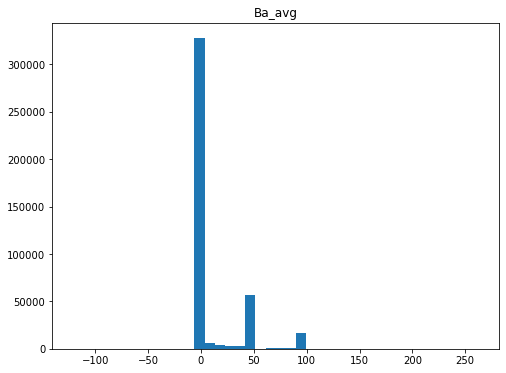

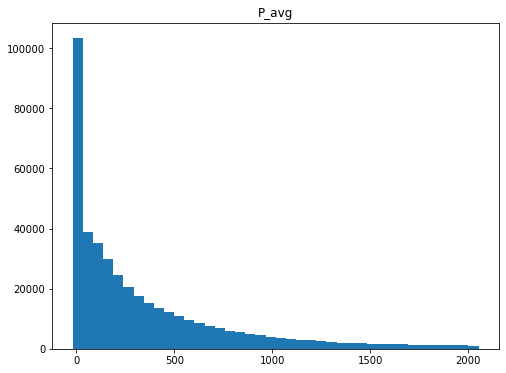

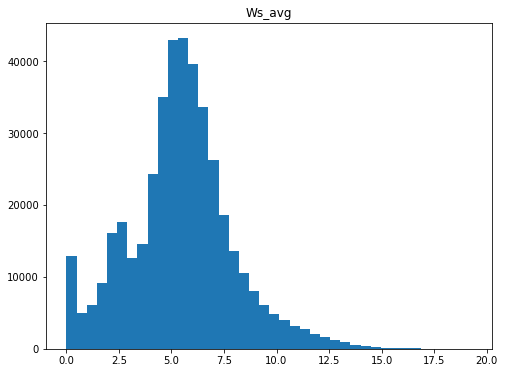

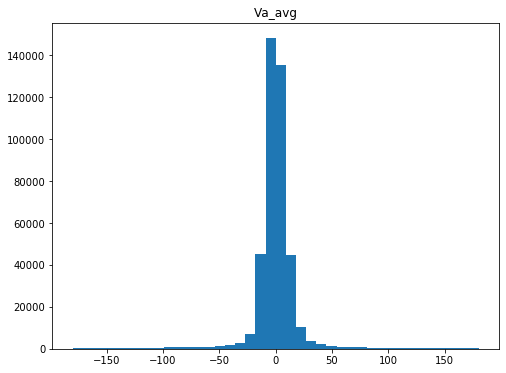

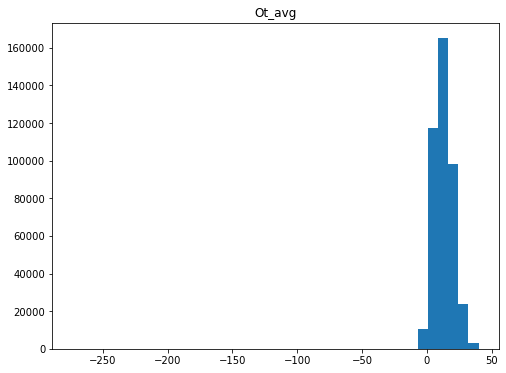

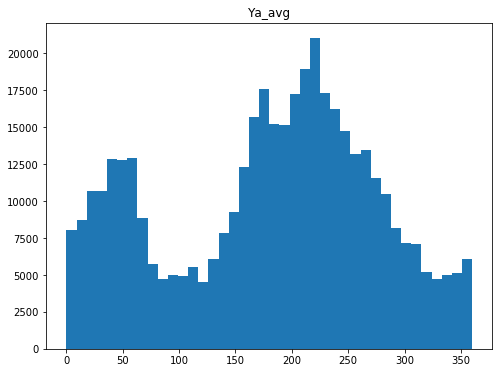

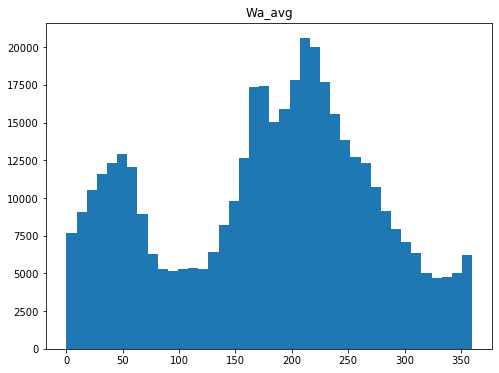

In [78]:
qc.column_histograms()

### Check ranges of each variable

In [79]:
qc._max_min

,min,max
Wind_turbine_name,R80711,R80790
Date_time,2014-01-01T01:00:00+01:00,2016-01-01T00:50:00+01:00
Ba_avg,-121.26,262.61
P_avg,-17.92,2051.87
Ws_avg,0,19.31
Va_avg,-179.95,179.99
Ot_avg,-273.2,39.89
Ya_avg,0,360
Wa_avg,0,360
datetime,2014-01-01 01:00:00,2016-01-01 00:50:00


### These values look fairly reasonable and consistent. 

### Any timestamp duplications and timestamp gaps. Duplications in October and gaps in March would suggest DST.

In [80]:
qc._time_duplications 

50716    2014-03-30 03:00:00
50717    2014-03-30 03:00:00
50718    2014-03-30 03:00:00
50719    2014-03-30 03:00:00
50721    2014-03-30 03:10:00
50723    2014-03-30 03:10:00
50726    2014-03-30 03:10:00
50727    2014-03-30 03:10:00
50730    2014-03-30 03:20:00
50733    2014-03-30 03:20:00
50734    2014-03-30 03:20:00
50735    2014-03-30 03:20:00
50740    2014-03-30 03:30:00
50741    2014-03-30 03:30:00
50742    2014-03-30 03:30:00
50743    2014-03-30 03:30:00
50747    2014-03-30 03:40:00
50748    2014-03-30 03:40:00
50750    2014-03-30 03:40:00
50751    2014-03-30 03:40:00
50756    2014-03-30 03:50:00
50757    2014-03-30 03:50:00
50758    2014-03-30 03:50:00
50759    2014-03-30 03:50:00
260379   2015-03-29 03:00:00
260380   2015-03-29 03:00:00
260382   2015-03-29 03:00:00
260383   2015-03-29 03:00:00
260387   2015-03-29 03:10:00
260388   2015-03-29 03:10:00
260390   2015-03-29 03:10:00
260391   2015-03-29 03:10:00
260395   2015-03-29 03:20:00
260396   2015-03-29 03:20:00
260398   2015-

In [81]:
qc._time_gaps

12678   2014-03-30 02:00:00
12679   2014-03-30 02:10:00
12680   2014-03-30 02:20:00
12681   2014-03-30 02:30:00
12682   2014-03-30 02:40:00
12683   2014-03-30 02:50:00
65094   2015-03-29 02:00:00
65095   2015-03-29 02:10:00
65096   2015-03-29 02:20:00
65097   2015-03-29 02:30:00
65098   2015-03-29 02:40:00
65099   2015-03-29 02:50:00
dtype: datetime64[ns]

### Based on the duplicated timestamps, it does seem like there is a dst correction in spring but no time gap in the fall

### Let's check the DST plot to look in more detail

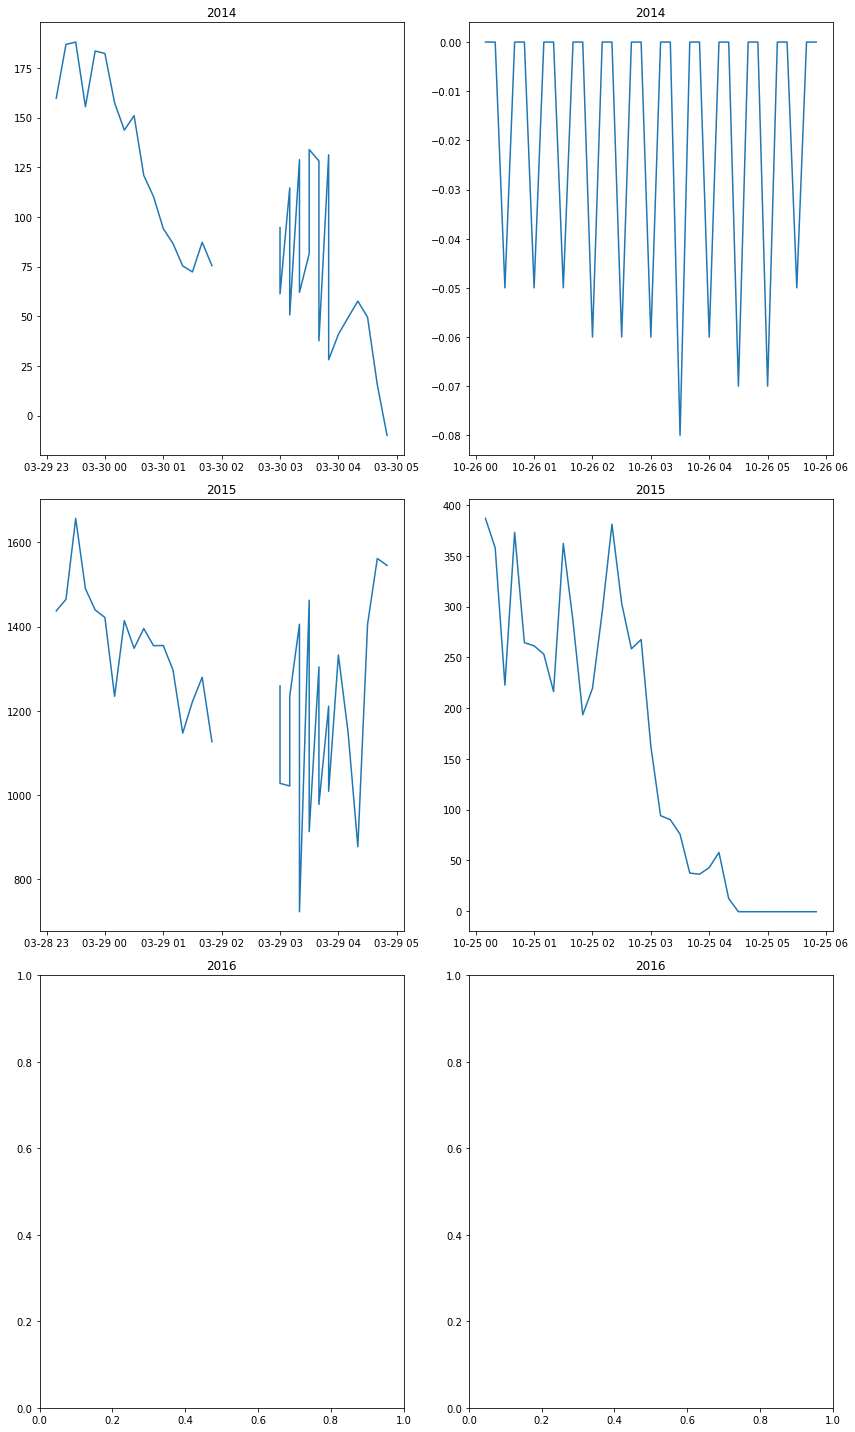

In [82]:
qc.daylight_savings_plot()

### So we do in fact have a gap in the spring data when DST kicks in but not duplicated data in the fall.

### The final question regarding datetime is whether we're in UTC or local. Given the daylights savings gap, it's likely we're in local. This if further confirmed by the raw datetime info provided in the SCADA file, which showed a +1h timezone from UTC. So we are operating in local time. Therefore, the project import script for La Haute Borne should shift the timestep back an hour to put it into UTC

### Now that we have gathered some useful information about our timeseries, the one last check we may want to make is to inspect each turbine profile. We can look at each turbine's power curve and perform an initial scan for irregularities.

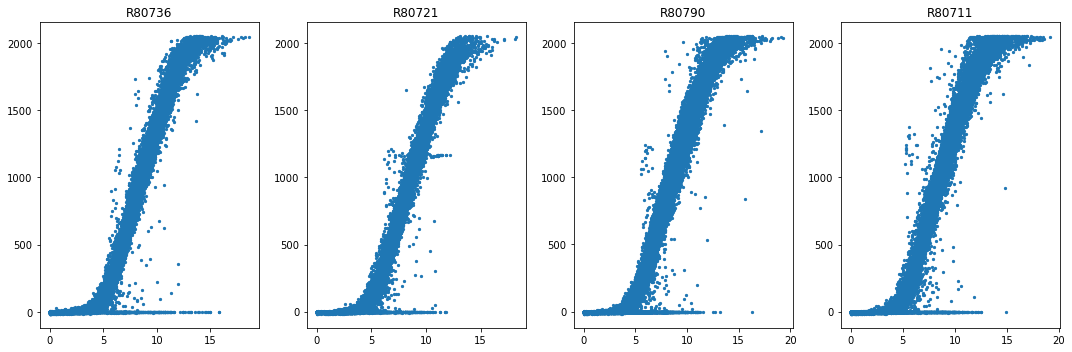

In [85]:
qc.plot_by_id('Ws_avg', 'P_avg')

### Overall, these power curves look pretty common with some downtime and what look like a few erroneous data points. 

## Step 4: Performing adjustments on our data

#### Recall that this notebook is only for diagnostic QC of plant data and does not actually change the data in the project import script. Any issues identifed here should be incorporated into the project import script.